#   Reference
https://datasciocean.tech/deep-learning-core-concept/backpropagation-explain/


In [852]:
# Import Libs
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(42)  # For reproducibility

In [853]:
# Functions to generate datasets


# The size of  training,test data are both n by 2
def generate_linear(n=100):

    import numpy as np

    pts = np.random.uniform(0, 1, (n, 2))
    inputs = []
    labels = []
    for pt in pts:
        inputs.append([pt[0], pt[1]])
        distance = (pt[0] - pt[1]) / 1.414
        if pt[0] > pt[1]:
            labels.append(0)
        else:
            labels.append(1)
    return np.array(inputs), np.array(labels).reshape(n, 1)


def generate_XOR_easy():
    import numpy as np

    inputs = []
    labels = []

    for i in range(11):
        inputs.append([0.1 * i, 0.1 * i])
        labels.append(0)

        if 0.1 * i == 0.5:
            continue

        inputs.append([0.1 * i, 1 - 0.1 * i])
        labels.append(1)

    return np.array(inputs), np.array(labels).reshape(21, 1)

In [854]:
# Plot results


def show_result(x, y, pred_y):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Ground Truth", fontsize=18)
    for i in range(x.shape[0]):
        if y[i] == 0:
            plt.plot(x[i][0], x[i][1], "ro")
        else:
            plt.plot(x[i][0], x[i][1], "bo")
    plt.subplot(1, 2, 2)
    plt.title("Predict result", fontsize=18)

    for i in range(x.shape[0]):
        if pred_y[i] == 0:
            plt.plot(x[i][0], x[i][1], "ro")
        else:
            plt.plot(x[i][0], x[i][1], "bo")

    plt.show()

In [855]:
# Activative functions and their derivatives
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))


def derivative_sigmoid(x):
    return np.multiply(x, 1.0 - x)


def relu(x):
    return np.maximum(0, x)


def derivative_relu(x):
    return np.where(x >= 0, 1, 0)


def tanh(x):
    return np.tanh(x)


def derivative_tanh(x):
    return 1.0 - np.square(np.tanh(x))


# Mean Squared Error (MSE) function
# Returns the average of the squared differences between predicted and true values and the derivative of MSE
# MSE is defined as:
# MSE = 1/n * Σ(y_true - y_pred)²
# where n is the number of samples, y_true is the true value, and y_pred
# Return value is already averaged over the number of samples
def MSE(y_true, y_pred):
    mse = np.sum(np.square(y_true - y_pred)) / y_true.shape[0]
    derivative = -2 * (y_true - y_pred) / y_true.shape[0]
    return mse, derivative


activation_map = {"sigmoid": sigmoid, "relu": relu, "tanh": tanh}
derivative_activation_map = {
    "sigmoid": derivative_sigmoid,
    "relu": derivative_relu,
    "tanh": derivative_tanh,
}

In [ ]:
# Fully connected layer class
class Linear_Layer:
    """
    Example:
        Input : (n,m,activation function) , the weight maxtrix W is n by m
        z = xW + b , with size
        a = activation(z)
        delta : size m by 1
        dc : delta value of current layer
        dn : delta value of next layer (forward pass direction : layer c -> layer n)

        the delta value of output layer  = dC/da * derivative of activation function with input z

        the delta value of hidden layer = W^T(weight of current layer and next layer) * dn  * derivative of activation function with input z

        the gradient of weight matrix W = input * delta
        the gradient of bias b = delta
    """

    def __init__(self, input_size, output_size, activation="sigmoid"):

        self.input_size = input_size
        self.output_size = output_size
        # Initialize weights and bias (W , b)
        # Assume that the size of input vector is  n by 1
        # The size of weight matrix should be m by n, where m is the size of output vector
        

        self.weights = np.random.randn(input_size, output_size)
            
        self.bias = np.random.randn(1, output_size)
        
        self.input = None
        self.a = None  # The output of the layer after activation function is applied
        self.z = None  # The output of the layer before activation function is applied (z = Wx + b)
        self.activation = activation

    #   Forward pass: z = xW + b
    def forward(self, x):
        self.input = x
        self.z = np.dot(x, self.weights) + self.bias

        if not self.activation:
            self.a = self.z
        else:
            self.a = activation_map[self.activation](self.z)

        return self.a

    def backward(self, upstream_delta, learning_rate=0.01):
        # check whether the activation function is empty
        if not self.activation:
            delta = upstream_delta
            # If no activation function, delta is just upstream_delta
        else:
            delta = upstream_delta * derivative_activation_map[self.activation](self.a)

        # Calculate gradients of weights and bias
        dW = np.dot(self.input.T, delta)
        db = np.sum(delta)

        # Update weights and bias
        self.weights -= dW * learning_rate
        self.bias -= db * learning_rate

        return np.dot(delta, self.weights.T)  # Return delta for the previous layer


# TODO : model with hyperparameters
class Model:

    def __init__(
        self, input_size=2, output_size=1, hidden_layers_size=10, activation="sigmoid"
    ):
        self.losses = []
        self.layers = []
        # Build model
        self.layers.append(Linear_Layer(input_size, hidden_layers_size, activation))
        self.layers.append(
            Linear_Layer(hidden_layers_size, hidden_layers_size, activation)
        )
        self.layers.append(Linear_Layer(hidden_layers_size, output_size, activation))

    def forward(self, x):
        # Forward pass through all layers
        for layer in self.layers:
            x = layer.forward(x)

        return x

    def backward(self, delta, learning_rate=0.01):
        # Backward pass
        for layer in reversed(self.layers):
            delta = layer.backward(delta, learning_rate)

    # Train the model
    # # x : input data, y : ground truth labels
    def train(self, x, y, epochs=100000, learning_rate=0.01):

        for epoch in range(1, epochs + 1, 1):
            # Forward pass
            output = self.forward(x)

            # Compute loss and its derivative (delta is gradient of a batch)
            loss, delta = MSE(y, output)

            self.losses.append(loss)

            if (epoch) % 1000 == 0:
                print(f"Epoch {epoch}, Loss: {loss:.4f}")

            # Backward pass and update weights & bis
            self.backward(delta, learning_rate)

        # Print the final Results
        print("Prediction: ")
        for i in range(x.shape[0]):
            print(
                "Iter{} |       Ground Truth: {} |      Predict: {} |".format(
                    i + 1, y[i], output[i]
                )
            )

        print(
            "Loss = {:.4f} Accuracy = {:.2f}%".format(
                loss, np.mean((output > 0.5) == y) * 100
            )
        )
        return output

    def plot_learning_curve(self):
        import matplotlib.pyplot as plt

        plt.plot(self.losses)
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title("Learning Curve")
        plt.show()

Epoch 1000, Loss: 0.2491
Epoch 2000, Loss: 0.2491
Epoch 3000, Loss: 0.2491
Epoch 4000, Loss: 0.2491
Epoch 5000, Loss: 0.2490
Epoch 6000, Loss: 0.2490
Epoch 7000, Loss: 0.2490
Epoch 8000, Loss: 0.2489
Epoch 9000, Loss: 0.2487
Epoch 10000, Loss: 0.2482
Epoch 11000, Loss: 0.2463
Epoch 12000, Loss: 0.2290
Epoch 13000, Loss: 0.0835
Epoch 14000, Loss: 0.0830
Epoch 15000, Loss: 0.0830
Epoch 16000, Loss: 0.0830
Epoch 17000, Loss: 0.0830
Epoch 18000, Loss: 0.0830
Epoch 19000, Loss: 0.0830
Epoch 20000, Loss: 0.0830
Epoch 21000, Loss: 0.0830
Epoch 22000, Loss: 0.0830
Epoch 23000, Loss: 0.0830
Epoch 24000, Loss: 0.0830
Epoch 25000, Loss: 0.0830
Epoch 26000, Loss: 0.0830
Epoch 27000, Loss: 0.0830
Epoch 28000, Loss: 0.0830
Epoch 29000, Loss: 0.0830
Epoch 30000, Loss: 0.0830
Epoch 31000, Loss: 0.0830
Epoch 32000, Loss: 0.0830
Epoch 33000, Loss: 0.0830
Epoch 34000, Loss: 0.0830
Epoch 35000, Loss: 0.0830
Epoch 36000, Loss: 0.0830
Epoch 37000, Loss: 0.0830
Epoch 38000, Loss: 0.0830
Epoch 39000, Loss: 0.

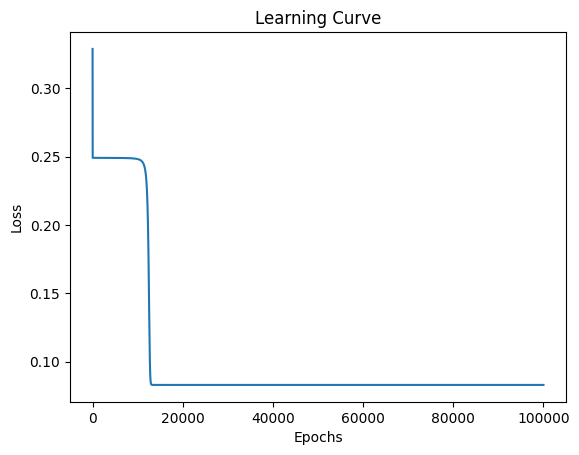

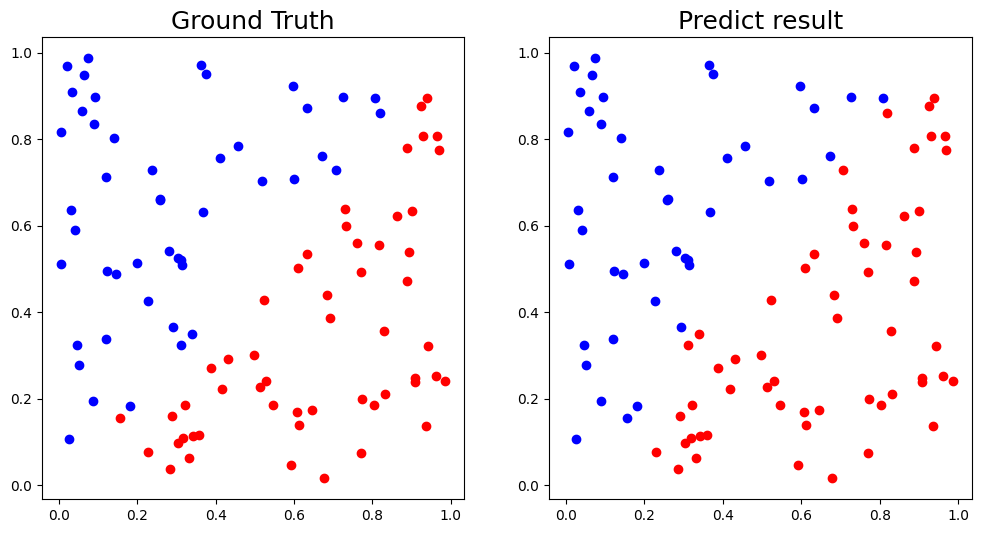

Epoch 1000, Loss: 0.2494
Epoch 2000, Loss: 0.2494
Epoch 3000, Loss: 0.2494
Epoch 4000, Loss: 0.2494
Epoch 5000, Loss: 0.2494
Epoch 6000, Loss: 0.2494
Epoch 7000, Loss: 0.2494
Epoch 8000, Loss: 0.2494
Epoch 9000, Loss: 0.2494
Epoch 10000, Loss: 0.2494
Epoch 11000, Loss: 0.2494
Epoch 12000, Loss: 0.2494
Epoch 13000, Loss: 0.2494
Epoch 14000, Loss: 0.2494
Epoch 15000, Loss: 0.2494
Epoch 16000, Loss: 0.2494
Epoch 17000, Loss: 0.2494
Epoch 18000, Loss: 0.2494
Epoch 19000, Loss: 0.2494
Epoch 20000, Loss: 0.2494
Epoch 21000, Loss: 0.2494
Epoch 22000, Loss: 0.2494
Epoch 23000, Loss: 0.2494
Epoch 24000, Loss: 0.2494
Epoch 25000, Loss: 0.2494
Epoch 26000, Loss: 0.2494
Epoch 27000, Loss: 0.2494
Epoch 28000, Loss: 0.2494
Epoch 29000, Loss: 0.2494
Epoch 30000, Loss: 0.2494
Epoch 31000, Loss: 0.2494
Epoch 32000, Loss: 0.2494
Epoch 33000, Loss: 0.2494
Epoch 34000, Loss: 0.2494
Epoch 35000, Loss: 0.2494
Epoch 36000, Loss: 0.2494
Epoch 37000, Loss: 0.2494
Epoch 38000, Loss: 0.2494
Epoch 39000, Loss: 0.

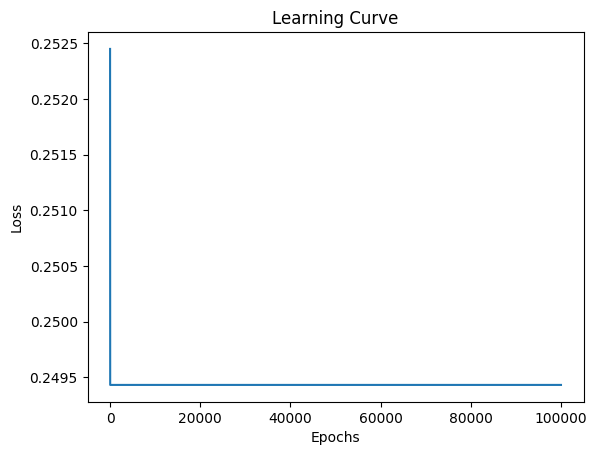

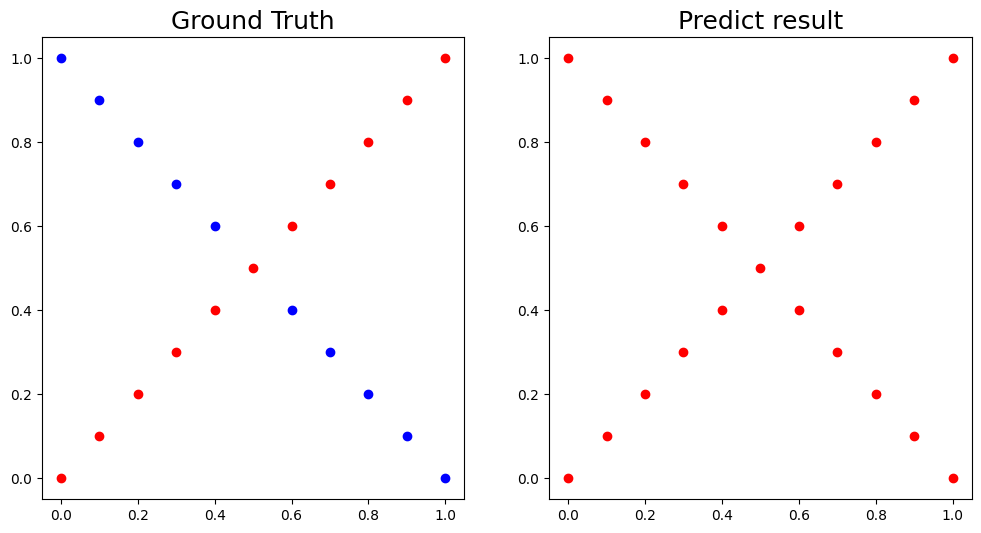

In [ ]:

# Linear dataset
x, y = generate_linear(n=100)


model_linear = Model(x.shape[1], y.shape[1], hidden_layers_size=10, activation="")
linear_output = model_linear.train(x, y)


model_linear.plot_learning_curve()
show_result(x, y, (linear_output) > 0.5)

# XOR dataset
x, y = generate_XOR_easy()
model_XOR = Model(x.shape[1], y.shape[1], hidden_layers_size=10, activation="")
XOR_output = model_XOR.train(x, y)
model_XOR.plot_learning_curve()
show_result(x, y, (XOR_output) > 0.5)


# TODO : Optimizer, 